In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import seaborn as sns
import scipy.optimize as optim

In [ ]:
# Parse files

In [2]:
def load_vna_data(data_loc, date_str, antenna_str_list):
    data =[]
    for item in os.listdir(data_loc): # look through the cres_probe dir.
        for ant in antenna_str_list:
            if item == date_str + '_' + ant: # check if the item matches the date and antenna.
                antenna_name = ant
                measurement_loc = os.path.join(data_loc, item)
                for run in os.listdir(measurement_loc):
                    if os.path.isdir(os.path.join(measurement_loc, run)):
                        run_num = int(run.split('run')[-1])
                        run_loc = os.path.join(measurement_loc, run)
                        # read metadata
                        with open(os.path.join(run_loc,'meta/meta.txt')) as infile:
                            reader = csv.reader(infile)
                            for i, line in enumerate(reader):
                                if i==1:
                                    run_rad = float(line[0])
                                    run_z_offset = float(line[1])
                        ##
                        for meas in os.listdir(run_loc):
                            if os.path.isfile(os.path.join(run_loc, meas)) and meas != '.DS_Store':
                                #print(meas)
                                angle = int(meas.split('.')[0])
                                #print(angle)
                                csv_file = os.path.join(run_loc, meas)
                                # read csv data file
                                with open(csv_file) as infile:
                                    reader = csv.reader(infile)
                                    for i, line in enumerate(reader):
                                        if i == 6:
                                            labels = line
                                            #print(line)
                                            N_sparams = (len(labels) - 1) // 2
                                            sparams = []
                                            for n in range(N_sparams):
                                                sparams.append(labels[2 * n + 1].split('(')[0])
                                        if i > 6 and len(line) > 1:
                                            entry = {'antenna': antenna_name, 'run': run_num, 'radius': run_rad,
                                                     'z_offset': run_z_offset, 'angle': angle}
                                            for n, key in enumerate(labels):
                                                #print(key)
                                                entry.update({key: float(line[n])})
                                            for n, sparam in enumerate(sparams):
                                                entry.update({sparam + '(MAG)': 10 * np.log10(float(line[2 * n + 1]) ** 2 + float(line[2 * n + 2]) ** 2)})
                                                entry.update({sparam + '(PHASE)': np.arctan2(
                                                                        float(line[2 * n + 2]), float(line[2 * n + 1]))})
                                            data.append(entry)
    return pd.DataFrame(data)

def load_translation_data(path):
    data =[]
    for item in os.listdir(path): # look through the cres_probe dir.
        if os.path.isfile(os.path.join(path, item)) and item != '.DS_Store':
                measurement_path = os.path.join(path, item)
                dist = int(item.split('.')[0])

                # read csv data file
                with open(measurement_path) as infile:
                    reader = csv.reader(infile)
                    for i, line in enumerate(reader):
                        if i == 6:
                            labels = line
                            #print(line)
                            N_sparams = (len(labels) - 1) // 2
                            sparams = []
                            for n in range(N_sparams):
                                sparams.append(labels[2 * n + 1].split('(')[0])
                        if i > 6 and len(line) > 1:
                            entry = {'d': dist}
                            for n, key in enumerate(labels):
                                #print(key)
                                entry.update({key: float(line[n])})
                            for n, sparam in enumerate(sparams):
                                entry.update({sparam + '(MAG)': 10 * np.log10(float(line[2 * n + 1]) ** 2 + float(line[2 * n + 2]) ** 2)})
                                entry.update({sparam + '(PHASE)': np.arctan2(
                                                        float(line[2 * n + 2]), float(line[2 * n + 1]))})
                            data.append(entry)
    return pd.DataFrame(data)
    


def plot_phase(data, antenna_list, radius_list, run_list, freq_list, x='angle', y=['S24'], ):
    plot_data = data[(data['antenna'].isin(antenna_list)) & (data['radius'].isin(radius_list)) & (data['run'].isin(run_list)) & (data['Freq(Hz)'].isin(freq_list))]
    fig = plt.figure(figsize=(8,6))
    fig.set_facecolor('white')
    axs = plt.subplot(1,1,1)
    #ax1 = plt.subplot
    for run in run_list:
        starting_phase = []
        x_data_list = []
        y_data_list = []
        for i, sparam in enumerate(y):
            x_data = np.asarray(plot_data[plot_data['run'] == run][x])
            #print(sparam + '(PHASE)')
            y_data = np.asarray(plot_data[plot_data['run'] == run][sparam+'(PHASE)'])

            y_data = y_data[np.argsort(x_data)]
            x_data = np.sort(x_data)

            y_data = np.unwrap(y_data)
            
            starting_phase.append(y_data[0])
        
            y_data -= y_data[0]
            
            #x_data = np.concatenate((x_data, x_data + x_data[-1], x_data + 2 * x_data[-1]))
            #y_data = np.concatenate((y_data, y_data + y_data[-1], y_data + 2 * y_data[-1]))
            
            x_data_list.append(x_data)
            y_data_list.append(y_data)
        
        for i in range(len(y_data_list)):
            plot_y = np.degrees(y_data_list[i] - starting_phase[i] + starting_phase[0])
            plot_x = x_data_list[i]
            axs.plot(x_data_list[i], plot_y, 
                     label = f'run {run}, {sparam}')
    
    return axs

def plot_mag(data, antenna_list, radius_list, run_list, freq_list, x='angle', y=['S24']):
    plot_data = data[(data['antenna'].isin(antenna_list)) & (data['radius'].isin(radius_list)) & (data['run'].isin(run_list)) & (data['Freq(Hz)'].isin(freq_list))]
    fig = plt.figure(figsize=(8,6))
    fig.set_facecolor('white')
    axs = plt.subplot(1,1,1, polar=True)
    
    for run in run_list:
        for sparam in y:
            x_data = np.asarray(plot_data[plot_data['run'] == run][x])
            #print(sparam + '(PHASE)')
            y_data = np.asarray(plot_data[plot_data['run'] == run][sparam+'(MAG)'])

            y_data = y_data[np.argsort(x_data)]
            x_data = np.sort(x_data)

            #y_data = np.unwrap(y_data)

            axs.plot(np.radians(x_data), y_data, label = f'run {run}, {sparam}')
    
    return axs

def calculate_stats_per_freq(data_pd, antenna, radius, z_offset, run):
    data = data_pd[(data_pd['antenna'].isin([antenna])) & (data_pd['radius'].isin([radius])) & (data_pd['z_offset'].isin([z_offset])) & (data_pd['run'].isin([run]))]
    freq = data['Freq(Hz)'].unique()
    for f in freq:
        freq_data = data[data['Freq(Hz)'] == f]

def plot_mag_dipole(data, antenna_list, radius_list, run_list, freq_list, x='angle', y=['S24']):
    plot_data = data[(data['antenna'].isin(antenna_list)) & (data['radius'].isin(radius_list)) & (data['run'].isin(run_list)) & (data['Freq(Hz)'].isin(freq_list))]
    fig = plt.figure(figsize=(8,6))
    fig.set_facecolor('white')
    axs = plt.subplot(1,1,1)
    
    for run in run_list:
        for sparam in y:
            x_data = np.asarray(plot_data[plot_data['run'] == run][x])
            y_data = np.asarray(plot_data[plot_data['run'] == run][sparam + '(MAG)'])

            y_data = y_data[np.argsort(x_data)]
            x_data[np.argwhere(x_data >= 180)] -= 360
            x_data = np.sort(x_data)

            #y_data = np.unwrap(y_data)

            axs.plot(x_data, y_data, label = f'run {run}, {sparam}')
    
    return axs

def plot_phase_dipole(data, antenna_list, radius_list, run_list, freq_list, x='angle', y=['S24']):
    plot_data = data[(data['antenna'].isin(antenna_list)) & (data['radius'].isin(radius_list)) & (data['run'].isin(run_list)) & (data['Freq(Hz)'].isin(freq_list))]
    fig = plt.figure(figsize=(8,6))
    fig.set_facecolor('white')
    axs = plt.subplot(1,1,1)
    
    for run in run_list:
            for sparam in y:
                x_data = np.asarray(plot_data[plot_data['run'] == run][x])
                y_data = np.asarray(plot_data[plot_data['run'] == run][sparam + '(PHASE)'])

                y_data = y_data[np.argsort(x_data)]
                x_data[np.argwhere(x_data >= 180)] -= 360
                x_data = np.sort(x_data)

                y_data = np.unwrap(y_data)

                axs.plot(x_data, y_data, label = f'run {run}, {sparam}')
    
    return axs

In [3]:
data_loc = '/Users/ziegler/iCloud/Documents/data/cres_probes'
date_str = '210602'
#antenna_str = ['cres1', 'loop1', 'dipole1']
antenna_str = ['dipole2']
data_pd = load_vna_data(data_loc, date_str, antenna_str)    
#m1 = data_pd[(data_pd['Freq(Hz)'] == 2.0e10) & (data_pd['run'] == 1)]['S23(PHASE)']
#m2 = data_pd[(data_pd['Freq(Hz)'] == 2.0e10) & (data_pd['run'] == 2)]['S32(PHASE)']

data_pd

,antenna,run,radius,z_offset,angle,Freq(Hz),S24(REAL),S24(IMAG),S24(MAG),S24(PHASE)
0,dipole2,1,10.0,0.0,6,2.000000e+10,-0.001750,-0.000973,-53.969907,-2.633884
1,dipole2,1,10.0,0.0,6,2.000203e+10,-0.001976,-0.000303,-53.985541,-2.989546
2,dipole2,1,10.0,0.0,6,2.000406e+10,-0.001954,0.000403,-54.000760,2.938294
3,dipole2,1,10.0,0.0,6,2.000609e+10,-0.001689,0.001055,-54.015639,2.583234
4,dipole2,1,10.0,0.0,6,2.000812e+10,-0.001215,0.001574,-54.030245,2.228441
...,...,...,...,...,...,...,...,...,...,...
185653,dipole2,1,10.0,0.0,198,2.649188e+10,-0.003463,-0.002874,-46.934535,-2.448909
185654,dipole2,1,10.0,0.0,198,2.649391e+10,-0.004244,-0.001530,-46.914388,-2.795651
185655,dipole2,1,10.0,0.0,198,2.649594e+10,-0.004522,0.000004,-46.894016,3.140722
185656,dipole2,1,10.0,0.0,198,2.649797e+10,-0.004261,0.001545,-46.873406,2.793832


In [1091]:
plot_antennas = ['cres1']
plot_sparams = ['S24']
plot_rads = [10.0]
plot_z = [0.0]
plot_runs = [2]
ifreq = 2600

plot_freqs = [data_pd[data_pd['antenna'] == plot_antennas[0]]['Freq(Hz)'].unique()[ifreq]]

plot_data = data_pd[(data_pd['antenna'].isin(plot_antennas)) & (data_pd['radius'].isin(plot_rads)) & 
                    (data_pd['run'].isin(plot_runs)) & (data_pd['Freq(Hz)'].isin(plot_freqs))]

print(plot_freqs)
x = np.asarray(plot_data['angle'])
y = np.asarray(plot_data['S24(PHASE)'])

y = y[np.argsort(x)]
x = np.sort(x)

y = np.degrees(np.unwrap(y))

fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)

ax1.plot(x,y)

def fit_fun(x, a, b, c, d):
    
    return a * x + b * np.sin(2 * np.pi * x / 360 + c) + d

fit_params, fit_cov = optim.curve_fit(fit_fun, x, y)
print(fit_params)
print(fit_cov)
fit_x = np.arange(0, 360, 1)
fit_y = fit_params[0] * fit_x + fit_params[1] * np.sin(
    2 * np.pi * fit_x / 360 + fit_params[2]) + fit_params[3]
ax1.plot(fit_x, fit_y)
ax1.plot(fit_x, fit_params[0] * fit_x + fit_params[3])
ax1.plot(fit_x, fit_params[1] * np.sin(2 * np.pi * fit_x / 360 + fit_params[2]) + fit_params[3])

ifreq_list = np.arange(50, 900, 25)
freq_list = []
osc_amp = []

for f in ifreq_list:
    plot_freqs = [data_pd[data_pd['antenna'] == plot_antennas[0]]['Freq(Hz)'].unique()[f]]
    plot_data = data_pd[(data_pd['antenna'].isin(plot_antennas)) & (data_pd['radius'].isin(plot_rads)) & 
                    (data_pd['run'].isin(plot_runs)) & (data_pd['Freq(Hz)'].isin(plot_freqs))]
    freq_list.append(plot_freqs[0])
    x = np.asarray(plot_data['angle'])
    y = np.asarray(plot_data['S24(PHASE)'])

    y = y[np.argsort(x)]
    x = np.sort(x)

    y = np.degrees(np.unwrap(y))
    fit_params, fit_cov = optim.curve_fit(fit_fun, x, y)
    
    osc_amp.append(fit_params[1])
    
ax2 = plt.subplot(122)
ax2.plot(freq_list, abs(np.array(osc_amp)), '.')
print(freq_list[0], freq_list[-1])

def fit_fun(x, a, b):
    
    return a * x + b 

fit_params, fit_cov = optim.curve_fit(fit_fun, freq_list, abs(np.array(osc_amp)))
print(fit_params)
#print(fit_cov)

fit_x = np.arange(20e9, 26.5e9, 1e8)
fit_y = fit_fun(fit_x, fit_params[0], fit_params[1])

ax2.plot(fit_x, fit_y)
ax2.set_xlabel('Angle(deg)')
ax2.set_ylabel('Fit Sinusoid Amplitude')
ax2.set_title('Fit Sinusoid Amplitude Correlates with Frequency')

ax1.set_xlabel('Angle (deg)')
ax1.set_ylabel('Phase (deg)')
ax1.set_title('CRES Antenna Phase Fit')

#plt.savefig('/Users/ziegler/plots/21512_sin_amp.png')

#ax2.plot()

pred_slope = np.degrees(2 * np.pi * 5e-1 / 3e10)
print('Predicted Slope: ', pred_slope)
print('Fit Slope: ',fit_params[0])

IndexError: index 2600 is out of bounds for axis 0 with size 0

[24468750000.0]
Predicted Slope: 29.36
Fit Slope: 29.36


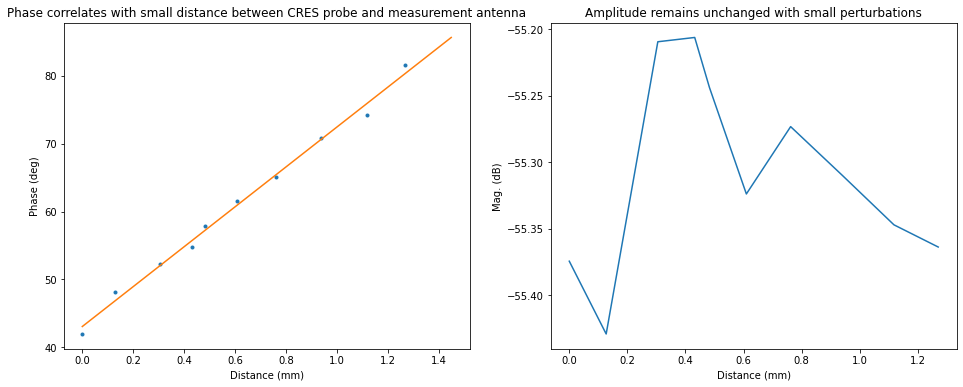

In [733]:
translation_path = '/Users/ziegler/iCloud/Documents/data/cres_probes/translation_test'

data_trans = load_translation_data(translation_path)

ifreq = 2200
plot_freqs = [data_trans['Freq(Hz)'].unique()[ifreq]]
print(plot_freqs)

plot_data = data_trans[(data_trans['Freq(Hz)'].isin(plot_freqs))]
plot_data
x = np.array(plot_data['d'])
y = np.degrees(np.array(plot_data['S34(PHASE)'])[np.argsort(x)])
x = np.sort(x) * 2.54e-2

fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
ax1.plot(x,y, '.')


def fit_fun(x, a, b):
    
    return a * x + b 

fit_params, fit_cov = optim.curve_fit(fit_fun, x, y)
#print(fit_params)
#print(fit_cov)

fit_x = np.arange(0, 1.5, 0.05)
fit_y = fit_fun(fit_x, fit_params[0], fit_params[1])

ax1.plot(fit_x, fit_y)

pred_slope = np.degrees(2 * np.pi * plot_freqs[0] / 3e11)
print('Predicted Slope: %.2f' % pred_slope)
print('Fit Slope: %.2f' % fit_params[0])

ax2 = plt.subplot(122)

ax2.plot(x, np.array(plot_data['S34(MAG)']))

ax2.set_xlabel('Distance (mm)')
ax2.set_ylabel('Mag. (dB)')
ax1.set_xlabel('Distance (mm)')
ax1.set_ylabel('Phase (deg)')

ax1.set_title('Phase correlates with small distance between CRES probe and measurement antenna')
ax2.set_title('Amplitude remains unchanged with small perturbations')

plt.savefig('/Users/ziegler/plots/21512_translation_test.png')

# CRES or Loop

Text(0.5, 1.0, 'Fits to Corrected Phases. Antenna: dipole2, Freq:  24.57 (GHz), S24')

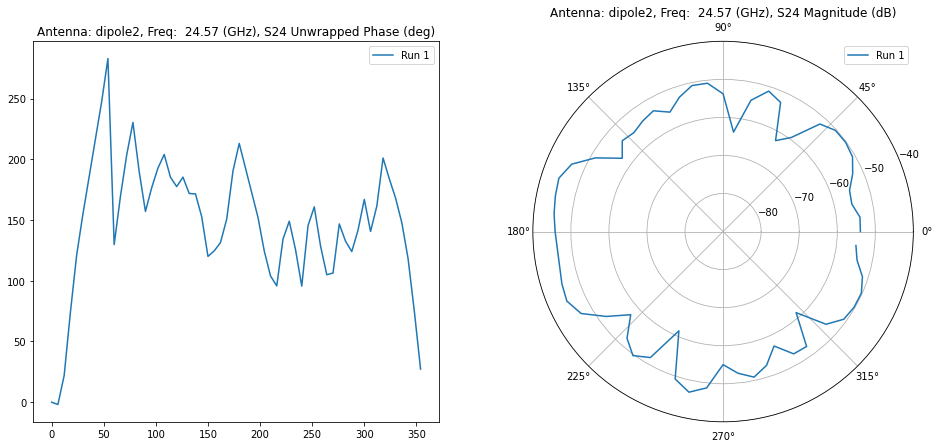

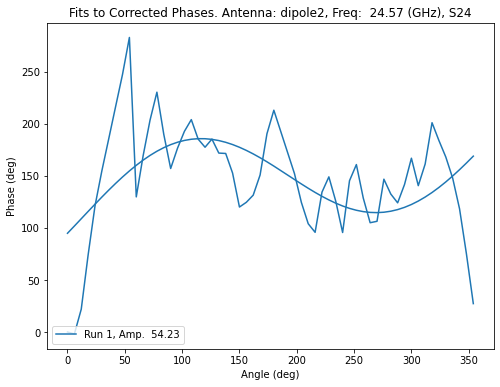

In [17]:
plot_antennas = ['dipole2']
plot_sparams = ['S24']
plot_rads = [10.0]
plot_z = [0.0]
plot_runs = [1]

ifreq = 2250
plot_freqs = [data_pd[data_pd['antenna'] == plot_antennas[0]]['Freq(Hz)'].unique()[ifreq]]
#print(plot_freqs)

plot_data = data_pd[(data_pd['antenna'].isin(plot_antennas)) & (data_pd['radius'].isin(plot_rads)) & 
                    (data_pd['run'].isin(plot_runs)) & (data_pd['Freq(Hz)'].isin(plot_freqs))]

x_list = []
phase_list = []
mag_list = []

for run in plot_runs:
    x = np.array(plot_data[plot_data['run'] == run]['angle'])
    #x[np.argwhere(x>180)] -=360
    y1 = np.array(plot_data[plot_data['run'] == run]['S24(PHASE)'])
    y2 = np.array(plot_data[plot_data['run'] == run]['S24(MAG)'])
    y1 = y1[np.argsort(x)]
    y2 = y2[np.argsort(x)]
   
    x = np.sort(x)
    
    y1 -= y1[0]
    y1 = np.unwrap(y1, discont=np.pi)
    
    #smooth_kern = np.ones(4) / 4
    #y1 = np.convolve(smooth_kern, y1, mode='same')
    y1 = np.degrees(y1)
    
    
    x_list.append(x)
    phase_list.append(y1)
    mag_list.append(y2)


fig1 = plt.figure(figsize=(16,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, polar=True)
for run in [0]:
    #if run == 2:
    #    phase_list[run] = ((phase_list[run][0:52]))
    #    mag_list[run] = ((mag_list[run][0:52]))
    #    x_list[run] = ((x_list[run][0:52]))
    #    phase_list[run][np.argwhere(x_list[run] >= 312)] -= 360
    #if run == 1:
        #phase_list[run] = ((phase_list[run][0:52]))
        #mag_list[run] = ((mag_list[run][0:52]))
        #x_list[run] = ((x_list[run][0:52]))
    #    phase_list[run][np.argwhere(x_list[run] >= 270)] += 360
    #if run == 0:
    #    phase_list[run][np.argwhere(x_list[run] >= 168)] -= 360
    ax1.plot(x_list[run], phase_list[run], label=f'Run {run + 1}')
    ax2.plot(np.radians(x_list[run]), mag_list[run], label=f'Run {run + 1}')
    ax2.set_ylim(-90,-40)
    ax1.legend(loc=1)
    ax2.legend(loc=1)
    #print(np.arange(0, 360, 6)[25:35])
#ax1.set_xlim(-60, 60)
ax1.set_title(f'Antenna: {plot_antennas[0]}, Freq: {plot_freqs[0] * 1e-9: .2f} (GHz), {plot_sparams[0]} Unwrapped Phase (deg)')
ax2.set_title(f'Antenna: {plot_antennas[0]}, Freq: {plot_freqs[0] * 1e-9: .2f} (GHz), {plot_sparams[0]} Magnitude (dB)')

#plt.savefig('/Users/ziegler/plots/21517_loop2_mag_and_phase_f3.png')

corrected_phase_list = []
for run in [0]:
    y = phase_list[run]
#    if run == 2:
#        y[np.argwhere(x_list[run] >= 138)] -= 360
    #if run == 0 or run ==1:
    #    y[np.argwhere(x_list[run] >= 132)] += 360
    corrected_phase_list.append(y)
        


def fit_fun(x, a, b, c, d):
    return a * x + b * np.sin((2 * np.pi * x / 360) + c) + d

fig2 = plt.figure(figsize=(8,6))
ax3 = plt.subplot(111)
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
for run in [0]:
    p, cov = optim.curve_fit(fit_fun, x_list[run], phase_list[run])
    #print(np.degrees(p[1]) % 360)
    ax3.plot(x_list[run], corrected_phase_list[run], color=colors[run], label=f'Run {run+1}, Amp. {p[1]: .2f}')
    ax3.plot(x_list[run], fit_fun(x_list[run], p[0], p[1], p[2], p[3]), color=colors[run])
    #ax3.plot(x_list[run], phase_list[run])
    #ax3.plot(x_list[run], fit_fun(x_list[run], p[0], p[1], p[2], p[3]), label='Fit')
    #ax3.plot(x_list[run], p[0] * x_list[run] + p[3], label=f'Linear, Slope {p[0]: .2f}')
    #ax3.plot(x_list[run], p[1] * np.sin(2 * np.pi * x_list[run] / 360 + p[2]) + p[3], label=f'Sine, Amp {p[1]: .2f}')
    
ax3.legend(loc=3)
ax3.set_xlabel('Angle (deg)')
ax3.set_ylabel('Phase (deg)')
ax3.set_title(f'Fits to Corrected Phases. Antenna: {plot_antennas[0]}, Freq: {plot_freqs[0] * 1e-9: .2f} (GHz), {plot_sparams[0]}')
#plt.savefig('/Users/ziegler/plots/21513_cres2_phase_fit.png')

# Dipole

[23250000000.0]


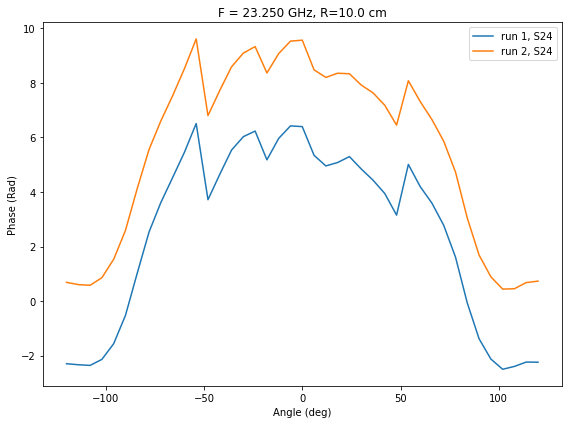

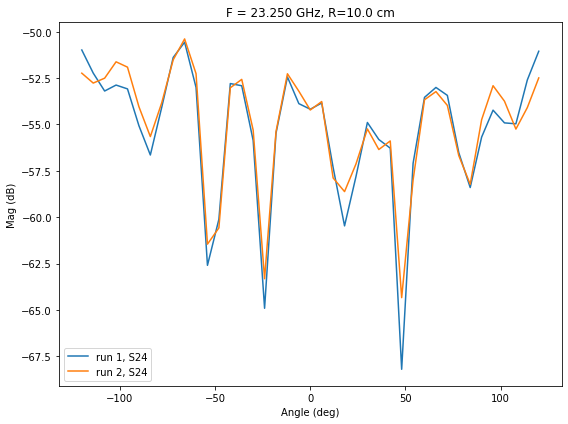

In [246]:
plot_antennas = ['dipole1']
plot_sparams = ['S24']
plot_rads = [10.0]
plot_z = [0.0]
plot_runs = [1,2]

ifreq = 500
plot_freqs = [data_pd[data_pd['antenna'] == plot_antennas[0]]['Freq(Hz)'].unique()[ifreq]]
print(plot_freqs)

axes_phase = plot_phase_dipole(data_pd, plot_antennas, plot_rads, plot_runs, plot_freqs, x='angle', y=plot_sparams)
axes_phase.set_title('F = %.3f GHz, R=%.1f cm' % (plot_freqs[0] * 1e-9, plot_rads[0]))
axes_phase.legend(loc=0)
axes_phase.set_xlabel('Angle (deg)')
axes_phase.set_ylabel('Phase (Rad)')
plt.tight_layout()
plt.savefig('/Users/ziegler/plots/21510_dipole1_phase.png')

axes_mag = plot_mag_dipole(data_pd, plot_antennas, plot_rads, plot_runs, plot_freqs, x='angle', y=plot_sparams)
axes_mag.set_title('F = %.3f GHz, R=%.1f cm' % (plot_freqs[0] * 1e-9, plot_rads[0]))
axes_mag.legend(loc=0)
axes_mag.set_xlabel('Angle (deg)')
axes_mag.set_ylabel('Mag (dB)')
plt.tight_layout()
plt.savefig('/Users/ziegler/plots/21510_dipole1_mag.png')

Text(0, 0.5, 'Phase (rad)')

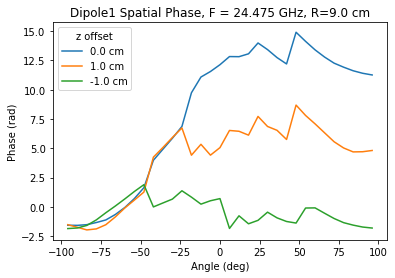

In [337]:
plot_antennas = ['dipole1']
plot_rads = [9.0]
plot_z = [0.0, 1.0, -1.0]

cres1_freqs = data_pd[data_pd['antenna'] == 'cres1']['Freq(Hz)'].unique()
loop1_freqs = data_pd[data_pd['antenna'] == 'loop1']['Freq(Hz)'].unique()
dipole1_freqs = data_pd[data_pd['antenna'] == 'dipole1']['Freq(Hz)'].unique()

plot_freqs = [dipole1_freqs[0]]

#plot_mag(data_pd, plot_antennas, plot_rads, plot_z, plot_freqs, x='angle', y='S42(MAG)')

axes_phase = plot_phase_dipole(data_pd, plot_antennas, plot_rads, plot_z, plot_freqs, x='angle', y='S42(PHASE)')
axes_phase.set_title('Dipole1 Spatial Phase, F = %.3f GHz, R=%.1f cm' % (plot_freqs[0] * 1e-9, plot_rads[0]))
axes_phase.legend(loc=0, title='z offset')
axes_phase.set_xlabel('Angle (deg)')
axes_phase.set_ylabel('Phase (rad)')
#plt.savefig('/Users/ziegler/plots/2021429_loop1_phase_meas_rad9cm.png')

# plots for a specific frequency

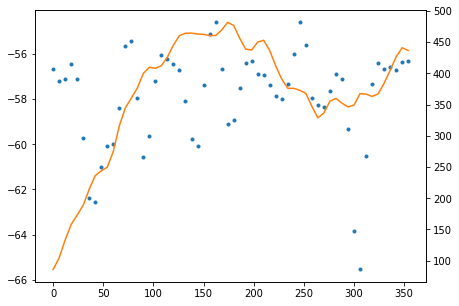

In [119]:
listdata = []
M = 2
for path in datapathlist:
    listdata.append(vna_to_pd(path))


frequencies = listdata[0]['Freq(Hz)'].unique()
plot_freq_ind = 100
plot_freq = frequencies[plot_freq_ind]
#print(listdata[0].loc[listdata[0]['Freq(Hz)'] == plot_freq])
plot_data = (listdata[M].loc[listdata[M]['Freq(Hz)'] == plot_freq])
plot_data = plot_data.iloc[np.argsort(plot_data['pos'])]

fig1 = plt.figure(figsize=(7,5)) 
ax1 = plt.subplot(1, 1, 1)

ax1.plot(plot_data['pos'], plot_data['S42(MAG)'], '.', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(plot_data['pos'], np.degrees(np.unwrap(np.radians(np.asarray(plot_data['S42(PHASE)'])))), color='tab:orange')
#ax1.set_ylim(-50, -60)

#fig2 = plt.figure(figsize=(7,5)) 
#ax3 = plt.subplot(1, 1, 1, projection = 'polar')

#ax3.plot(np.asarray(plot_data['S42(PHASE)']), np.ones(len(plot_data['S42(PHASE)'])), '.')


In [101]:
plot_data

,pos,Freq(Hz),S42(REAL),S42(IMAG),S42(MAG),S42(PHASE)
2311,0.0,2.530000e+10,0.000104,0.001467,-56.649199,85.938159
100,6.0,2.530000e+10,-0.000337,0.001341,-57.186013,104.106216
9547,12.0,2.530000e+10,-0.000952,0.001022,-57.098676,132.991160
5728,18.0,2.530000e+10,-0.001393,0.000568,-56.452420,157.814759
6130,24.0,2.530000e+10,-0.001386,0.000173,-57.094297,172.873666
5929,30.0,2.530000e+10,-0.001021,-0.000157,-59.720889,-171.266958
4120,36.0,2.530000e+10,-0.000628,-0.000428,-62.389610,-145.741307
1909,42.0,2.530000e+10,-0.000415,-0.000618,-62.560561,-123.859773
10351,48.0,2.530000e+10,-0.000394,-0.000801,-60.988875,-116.212840
301,54.0,2.530000e+10,-0.000343,-0.000931,-60.068108,-110.239145
